In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/samples.zip

Streaming output truncated to the last 5000 lines.
  inflating: samples/X/1002.png      
  inflating: samples/X/1003.png      
  inflating: samples/X/1004.png      
  inflating: samples/X/1005.png      
  inflating: samples/X/1006.png      
  inflating: samples/X/1007.png      
  inflating: samples/X/1008.png      
  inflating: samples/X/1009.png      
  inflating: samples/X/1010.png      
  inflating: samples/X/1011.png      
  inflating: samples/X/1012.png      
  inflating: samples/X/1013.png      
  inflating: samples/X/1014.png      
  inflating: samples/X/1015.png      
  inflating: samples/X/1016.png      
  inflating: samples/X/1017.png      
  inflating: samples/X/1018.png      
  inflating: samples/X/1019.png      
  inflating: samples/X/1020.png      
  inflating: samples/X/1021.png      
  inflating: samples/X/1022.png      
  inflating: samples/X/1023.png      
  inflating: samples/X/1024.png      
  inflating: samples/X/1025.png      
  inflating: samples/X/1026.png      

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
batch_size = 16
image_size = 64  # Keep this as is, but note that EfficientNet models work better with higher resolution images
num_classes = 29  # 29 classes for A-Z, del, space, nothing
epochs = 50
train_len = 58000  # Adjust based on your dataset

In [5]:
train_dir = '/content/samples'

In [6]:
import numpy as np
import os
import cv2
import skimage.transform
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2 # Import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# Set up ImageDataGenerator with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest',  # Filling the new pixels created by augmentation
    validation_split=0.3  # 30% for validation
)

In [8]:
# Validation data generator only rescaling
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [9]:
# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

Found 40600 images belonging to 29 classes.


In [10]:

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 17400 images belonging to 29 classes.


In [11]:
# Build MobileNetV2 Model (same as before)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D instead of Flatten for MobileNetV2
x = Dense(256, activation='relu')(x)  # Add fully connected layer

predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for classification
model = Model(inputs=base_model.input, outputs=predictions)

<ipython-input-11-ec92c3f734d8>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4)
checkpoint_filepath = 'checkpoints/best_model_mobilenet.weights.h5'  # Save MobileNetV2 weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
# Train the model with the ImageDataGenerator
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, model_checkpoint_callback],
    verbose=2
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2538/2538 - 238s - 94ms/step - accuracy: 0.8141 - loss: 0.6118 - val_accuracy: 0.6332 - val_loss: 1.6108
Epoch 2/50
2538/2538 - 154s - 61ms/step - accuracy: 0.8796 - loss: 0.3668 - val_accuracy: 0.6089 - val_loss: 1.6674
Epoch 3/50
2538/2538 - 195s - 77ms/step - accuracy: 0.8997 - loss: 0.3140 - val_accuracy: 0.6297 - val_loss: 1.5117
Epoch 4/50
2538/2538 - 149s - 59ms/step - accuracy: 0.9051 - loss: 0.2950 - val_accuracy: 0.6247 - val_loss: 1.6937
Epoch 5/50
2538/2538 - 202s - 80ms/step - accuracy: 0.9109 - loss: 0.2724 - val_accuracy: 0.6123 - val_loss: 1.7706
Epoch 6/50
2538/2538 - 148s - 58ms/step - accuracy: 0.9194 - loss: 0.2519 - val_accuracy: 0.6286 - val_loss: 1.9919
Epoch 7/50
2538/2538 - 147s - 58ms/step - accuracy: 0.9202 - loss: 0.2467 - val_accuracy: 0.6310 - val_loss: 1.9770


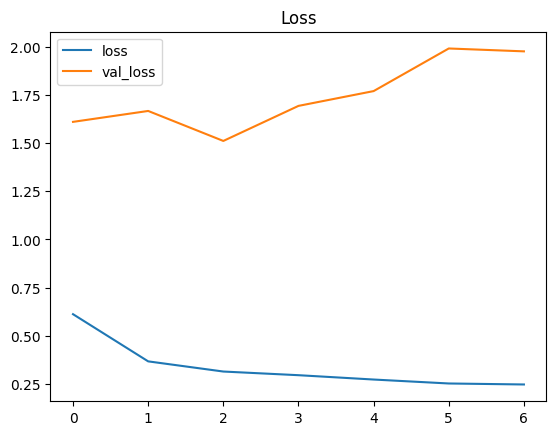

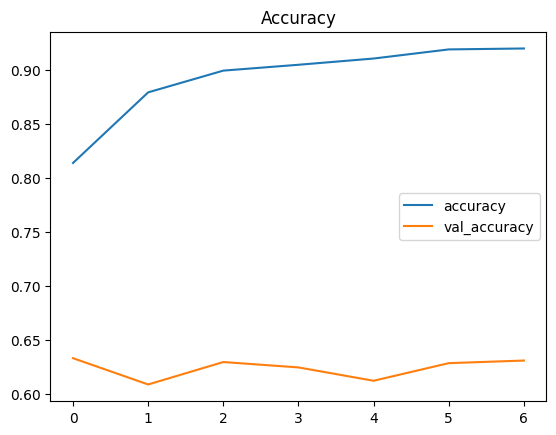

In [16]:
# Plot metrics
metrics = pd.DataFrame(history.history)

metrics[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

metrics[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

In [17]:
# Evaluate the model on validation data
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

Validation Accuracy: 63.10%


In [18]:
# Make predictions
predictions = model.predict(validation_generator)
predictions_classes = np.argmax(predictions, axis=1)

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step


In [19]:
# Ground truth labels
y_true = validation_generator.classes

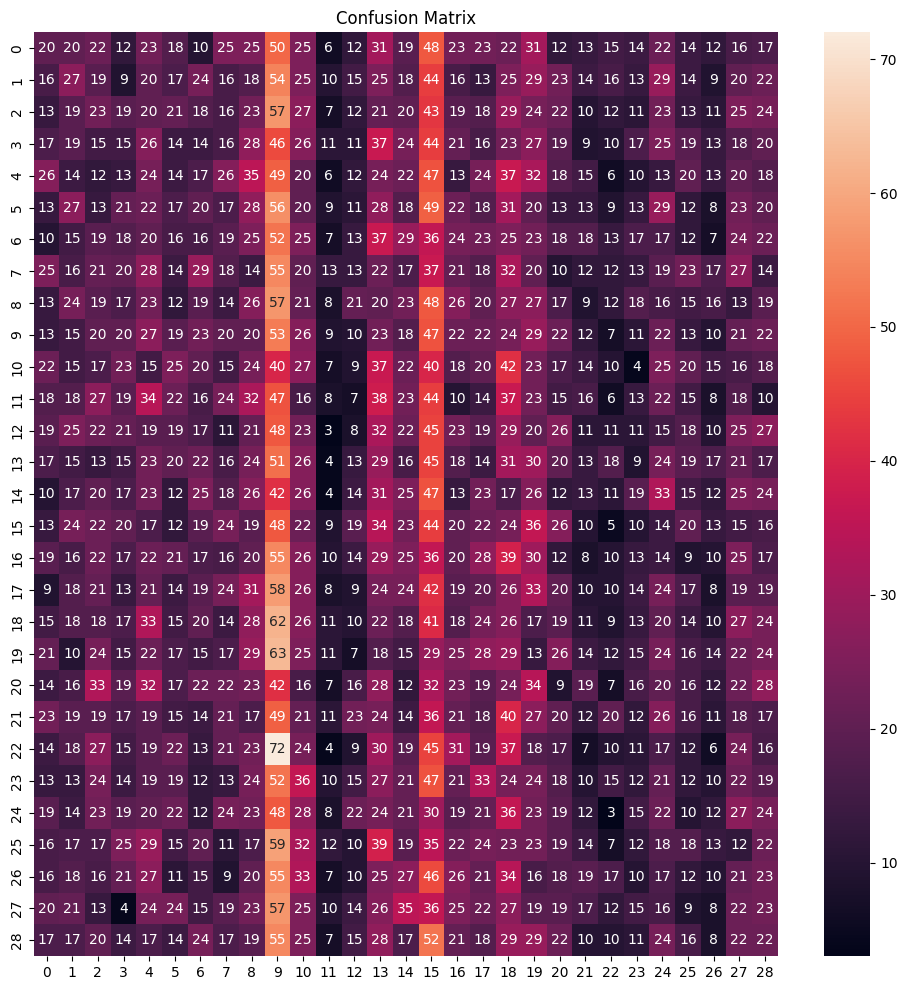

In [20]:

# Confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(y_true, predictions_classes), annot=True)
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Save the MobileNetV2 model
model.save('MobileNetV2.h5')  # Save the model

In [22]:
print(predictions_classes)  # Predicted classes
print(y_true)  # Actual classes

[15 10 22 ... 11  0 19]
[ 0  0  0 ... 28 28 28]
